In [1]:
##########################################################################################################
# Author: Mihaly Sulyok & Peter Karacsonyi                                                               #
# Last updated: 2023 Dec 10                                                                              #
# This workbook does wsi preprocessing with Pathml version 2.1.1                                         #
# Input: wsi image files, tested with OpenSlide .tif                                                     #
# Transformations: MedianBlur, BinaryThreshold, Tiling, MorphOpen, MorphClose, ForegroundDetection       #
# Read more on transformations: https://pathml.readthedocs.io/en/latest/examples/link_gallery.html       #
# Output: h5path files (https://pathml.readthedocs.io/en/latest/h5path.html)                             #
##########################################################################################################

# local imports
import os
if os.name == 'nt':
    import helpers.openslideimport #on windows, openslide needs to be installed manually, check local openslideimport.py

# global imports
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# pathml imports
from pathml import types
from pathml.core import SlideData, SlideDataset
from pathml.preprocessing import Pipeline, TissueDetectionHE

#########
# usage #
#########

#####################
# configure folders #
#####################

# set working directory
base_dir = Path("G:\\placenta")
# base_dir = Path("/mnt/g/xyz/") # linux
# wsi folder
wsi_subfolder = "wsi"
# place geojsons into this folder inside base with same name as the image (echino23.tiff / echino38.gejson)
annotations_subfolder = "none"
# output h5path files to (will be created)
h5path_subfolder = "h5-td"
# filenames having this substring with endpoint, possibly having annotation
endpoint_filename = "endpoint"

#######################################
# configure transformation parameters #
#######################################

pipeline = Pipeline([
    # values are the best found for placenta wsis
    TissueDetectionHE(mask_name = "tissue", min_region_size=500,
                      threshold=30, outer_contours_only=True)
])

OpenSlide imported successfully


In [2]:
# relative directory generation (don't modify)
data_dir = base_dir / Path(wsi_subfolder)                       # input
annotations_subfolder = base_dir / Path(annotations_subfolder)  # input : need to pre-generate with annotation_batch_reader
h5_dir = base_dir / Path(h5path_subfolder)                      # output
h5_dir.mkdir(parents=True, exist_ok=True)                       # create if does not exist

# read wsi files
wsi_paths = list(data_dir.glob("*.tif*"))

# build list of SlideData objects, label with output class, add annotation
wsi_list = []
label = {}
annotation_mask = None
for wsi in wsi_paths:
    annotation_mask = None
    # label preparation based on filename
    if endpoint_filename in wsi.name.lower():
        label["class"] = 1
        try: 
            annotation_mask = np.load(f"{Path( annotations_subfolder / wsi.stem )}.npy", allow_pickle=True)
        except Exception as e:
            print(f"Annotation mask could not be loaded for {wsi.stem}, error: {e}")
            pass
    else: 
        label["class"] = 0
    label["filename"] = wsi.name.lower().split(".")[0]
    # adding annotation as a mask if present (better not add empty mask)
    if annotation_mask is not None:
        wsi_list.append(
            SlideData(
                wsi.as_posix(), 
                name = wsi.as_posix(), 
                backend = "openslide", 
                slide_type = types.HE,
                labels = label,
                masks = {"tumor": annotation_mask}
            )
        )
        print(f"annotation mask successfully appended")
    else:
        wsi_list.append(
            SlideData(
                wsi.as_posix(), 
                name = wsi.as_posix(), 
                backend = "openslide", 
                slide_type = types.HE,
                labels = label
            )
        )

del annotation_mask

# initialize a SlideDataset Object
slide_dataset = SlideDataset(wsi_list)
pass

c:\Users\mazsolamacko\anaconda3\envs\pathml\lib\site-packages\PIL\Image.py:3182: DecompressionBombWarning: Image size (98646360 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Read 6 wsi images: 


c:\Users\mazsolamacko\anaconda3\envs\pathml\lib\site-packages\PIL\Image.py:3182: DecompressionBombWarning: Image size (98646360 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


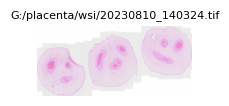

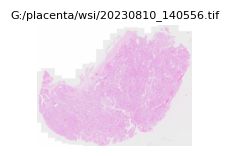

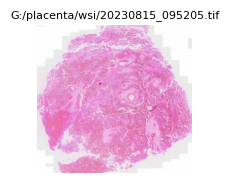

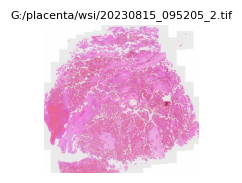

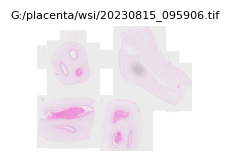

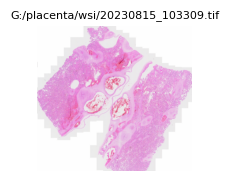

In [3]:
# Draw the images
print(f"Read {len(slide_dataset)} wsi images: ")
for slide in slide_dataset:
    _, axs = plt.subplots(figsize=(2, 2))
    slide.plot(ax=axs)
    axs.set_title(label=slide.name, fontsize=8)

In [4]:
# run preprocessing pipeline
start_time = time.time()
slide_dataset.run(
    pipeline,
    distributed=False, # distributed processing always crashes / memleak on wsl. on windows it throws OpenSlide DLL not found error
    # client = client, # distributed processing client
    tile_size=500, # best tile size is between 500 and 1000 pixel https://www.sciencedirect.com/science/article/pii/S2352914822000053
    overwrite_existing_tiles=True,
    write_dir=str(h5_dir), # The write_dir is buggy: places h5path files to where images were, so I move them to another dir...
)

# counting extracted tiles:
total_tiles = 0
for slide in slide_dataset.slides:
    total_tiles = total_tiles + len(slide.tiles.keys)

print(f"Total number of tiles extracted: {total_tiles}")

# move h5path files from wsi dir to a new dir
h5_dir.mkdir(0o644, parents=True, exist_ok=True)
h5_paths = list(data_dir.glob("*.h5path"))
print(f"Writing {len(h5_paths)} h5path images to {str(h5_dir)}: ")
for h5file in h5_paths:
    h5file.replace(h5_dir/h5file.name)
    print(h5_dir/h5file.name)

time_elapsed = time.time() - start_time
print('Preprocessing completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Total number of tiles extracted: 1837
Writing 6 h5path images to G:\placenta\h5-td: 
G:\placenta\h5-td\20230810_140324.tif.h5path
G:\placenta\h5-td\20230810_140556.tif.h5path
G:\placenta\h5-td\20230815_095205.tif.h5path
G:\placenta\h5-td\20230815_095205_2.tif.h5path
G:\placenta\h5-td\20230815_095906.tif.h5path
G:\placenta\h5-td\20230815_103309.tif.h5path
Preprocessing completed in 1m 29s
